In [27]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf

In [28]:
## LSTM 학습용을 위한 데이터 생성. window개념 포함.
def getSeriesData(data, window_size, elementdim=1, predict_size=1):
  '''
  window_size 만큼의 데이터로 다음 데이터를 예측하기 위한 학습데이터 생성
  :param data: [1,2,3,4,5]
  :param window_size:
  :param elementdim:
  :return: x=[1,2,3], y=[4], x=[2,3,4], y=[5]
  '''
  assert window_size < len(data)
  num = len(data) - window_size - predict_size + 1
  xdata = [data[i:i + window_size] for i in range(num)]
  ydata = [data[i + window_size:i + window_size + predict_size] for i in range(num)]
  
  x = np.array(xdata, dtype=np.float32).reshape((-1, window_size, elementdim))
  y = np.array(ydata, dtype=np.float32).reshape((-1, predict_size * elementdim))
  return x, y

In [29]:
# 학습용, 검증용, 테스트용 분할하기
def split_data(data, val_size=0.15, test_size=0.15):
  """
  splits data to training, validation and testing parts
  """
  ntest = int(round(len(data) * (1 - test_size)))
  nval = int(round(ntest * (1 - val_size)))
  
  train, validation, test = np.split(data, [nval, ntest])
  
  return train, validation, test

In [30]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [31]:
df = pd.read_csv('apple.csv', header=0)
print('df.columns : ', df.columns)
MAX_PRICE = df.Open.max()
print('MAX_PRICE : ', MAX_PRICE)
df = df[df.Open != 0][['Open']]
df.Open = df.Open / MAX_PRICE
xy = df.as_matrix()

train, validation, test = split_data(xy)
WINDOWSIZE = 30
train_x, train_y = getSeriesData(train, WINDOWSIZE, elementdim=1)
valid_x, valid_y = getSeriesData(validation, WINDOWSIZE, elementdim=1)
test_x, test_y = getSeriesData(test, WINDOWSIZE, elementdim=1)

print('TRAIN', train.shape)
print('TEST', test.shape)
print('TRAIN X', train_x.shape)
print('TRAIN Y', train_y.shape)


df.columns :  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
MAX_PRICE :  175.11
TRAIN (1460, 1)
TEST (303, 1)
TRAIN X (1430, 30, 1)
TRAIN Y (1430, 1)


In [32]:
                
# 모델 구성하기
model = Sequential()
hidden_nodes = 60
model.add(LSTM(hidden_nodes, input_shape=(WINDOWSIZE, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

# 모델 학습과정 설정하기
import keras
#opt = keras.optimizers.SGD(lr=0.1)
opt = keras.optimizers.Adam(lr=0.2, decay=0.99)
model.compile(loss='mean_squared_error', optimizer=opt)

class mykerasCB(keras.callbacks.Callback):
    def on_epoch_end(self, arga, argb):
        print('LR=', tf.to_float(self.model.optimizer.lr))


In [33]:
# 모델 학습하기
hist = model.fit(train_x, train_y, 
                 epochs=100, batch_size=int(train_x.shape[0] / 10), 
                 validation_data=(valid_x, valid_y), 
                 shuffle=True,
                 callbacks=[mykerasCB()],
                 verbose=1)

Train on 1430 samples, validate on 228 samples
Epoch 1/100
1430/1430 [==============================] - 2s 1ms/step - loss: 23.4515 - val_loss: 7.0426
Epoch 2/100
1430/1430 [==============================] - 1s 351us/step - loss: 6.0725 - val_loss: 3.2835
Epoch 3/100
1430/1430 [==============================] - 0s 335us/step - loss: 1.2840 - val_loss: 0.0971
Epoch 4/100
1430/1430 [==============================] - 0s 327us/step - loss: 0.3298 - val_loss: 0.0509
Epoch 5/100
1430/1430 [==============================] - 1s 357us/step - loss: 0.4364 - val_loss: 0.0334
Epoch 6/100
1430/1430 [==============================] - 0s 321us/step - loss: 0.3447 - val_loss: 0.0018
Epoch 7/100
1430/1430 [==============================] - 1s 365us/step - loss: 0.3139 - val_loss: 0.0181
Epoch 8/100
1430/1430 [==============================] - 1s 376us/step - loss: 0.2683 - val_loss: 0.0346
Epoch 9/100
1430/1430 [==============================] - 0s 310us/step - loss: 0.2688 - val_loss: 0.0364
Epoch 10/

Epoch 37/100
1430/1430 [==============================] - 0s 341us/step - loss: 0.2519 - val_loss: 0.0297
Epoch 38/100
1430/1430 [==============================] - 1s 373us/step - loss: 0.2542 - val_loss: 0.0302
Epoch 39/100
1430/1430 [==============================] - 1s 413us/step - loss: 0.2304 - val_loss: 0.0298
Epoch 40/100
1430/1430 [==============================] - 1s 365us/step - loss: 0.2495 - val_loss: 0.0295
Epoch 41/100
1430/1430 [==============================] - 0s 334us/step - loss: 0.2252 - val_loss: 0.0297
Epoch 42/100
1430/1430 [==============================] - 1s 352us/step - loss: 0.2478 - val_loss: 0.0300
Epoch 43/100
1430/1430 [==============================] - 1s 392us/step - loss: 0.2476 - val_loss: 0.0295
Epoch 44/100
1430/1430 [==============================] - 1s 358us/step - loss: 0.2505 - val_loss: 0.0296
Epoch 45/100
1430/1430 [==============================] - 0s 319us/step - loss: 0.2461 - val_loss: 0.0299
Epoch 46/100
1430/1430 [======================

Epoch 73/100
1430/1430 [==============================] - 1s 451us/step - loss: 0.2218 - val_loss: 0.0308
Epoch 74/100
1430/1430 [==============================] - 0s 327us/step - loss: 0.2263 - val_loss: 0.0301
Epoch 75/100
1430/1430 [==============================] - 0s 310us/step - loss: 0.2328 - val_loss: 0.0307
Epoch 76/100
1430/1430 [==============================] - 1s 409us/step - loss: 0.2211 - val_loss: 0.0312
Epoch 77/100
1430/1430 [==============================] - 1s 412us/step - loss: 0.2211 - val_loss: 0.0323
Epoch 78/100
1430/1430 [==============================] - 1s 361us/step - loss: 0.2436 - val_loss: 0.0329
Epoch 79/100
1430/1430 [==============================] - 0s 309us/step - loss: 0.2326 - val_loss: 0.0312
Epoch 80/100
1430/1430 [==============================] - 1s 361us/step - loss: 0.2250 - val_loss: 0.0304
Epoch 81/100
1430/1430 [==============================] - 0s 317us/step - loss: 0.2289 - val_loss: 0.0300
Epoch 82/100
1430/1430 [======================

In [18]:
# 모델 평가하기
testScore = model.evaluate(test_x, test_y, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

test_res = model.predict(test_x)

#print(test_y[:10, 0])
#print(test_res[:10, 0])

Test Score:  0.189480193041


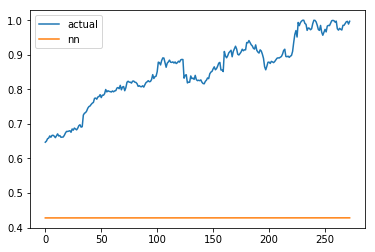

In [19]:

fig, ax = plt.subplots()
ax.plot(test_y[:, 0], label='actual')
ax.plot(test_res[:, 0], label='nn')
plt.legend()
plt.show()
